In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  #
from typing import Callable
from sklearn.metrics import classification_report, confusion_matrix

from classes.AlexNet import AlexNet


from utils.functions import plot_confusion_matrix, load_cifar10

In [11]:

# define model parameters
NUM_EPOCHS = 90  # original paper
BATCH_SIZE = 32
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 227  # pixels
NUM_CLASSES = 100  # 1000 classes for imagenet 2012 dataset
DEVICE_IDS = [0, 1, 2, 3]  # GPUs to use

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [13]:
# Defina as transformações para redimensionar e normalizar as imagens
transform = transforms.Compose([transforms.Resize((IMAGE_DIM, IMAGE_DIM)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [14]:
trainset, testset = load_cifar10(n_size=10, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# Defina o dataloader
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)


In [16]:

# Instancie a AlexNet
alexnet = AlexNet().to(device)


In [17]:
# Defina a função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)
# Treine a rede
num_epochs = 2
train_losses = []
test_losses = []

In [19]:

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    tqdm_trainloader = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}, Training', dynamic_ncols=True)

    for i, data in enumerate(tqdm_trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Mova os dados para o dispositivo correto

        optimizer.zero_grad()

        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        tqdm_trainloader.set_postfix({'loss': running_loss / (i + 1)})

    # Calcule a perda média no conjunto de treinamento
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Avalie o modelo no conjunto de teste
    alexnet.eval()
    running_test_loss = 0.0
    tqdm_testloader = tqdm(testloader, desc=f'Epoch {epoch+1}/{num_epochs}, Testing', dynamic_ncols=True)

    with torch.no_grad():
        for data in tqdm_testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Mova os dados para o dispositivo correto

            outputs = alexnet(inputs)
            test_loss = criterion(outputs, labels)
            running_test_loss += test_loss.item()

    # Calcule a perda média no conjunto de teste
    test_loss = running_test_loss / len(testloader)
    test_losses.append(test_loss)

    tqdm_trainloader.set_postfix({'Training Loss': train_loss, 'Testing Loss': test_loss})
    tqdm_trainloader.close()
    tqdm_testloader.close()

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1/2, Training:   0%|          | 0/157 [00:00<?, ?it/s]/home/rlass/codes/trabalho_pratico_visao_comp/.venv/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: Error detected in ReluBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/rlass/codes/trabalho_pratico_visao_comp/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/rlass/codes/trabalho_pratico_visao_comp/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance
    app.start()
  File "/home/rlass/codes/trabalho_pratico_visao_comp/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/rlass/codes/trabalho_pratico_visao_comp/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in star

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [32, 4096]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

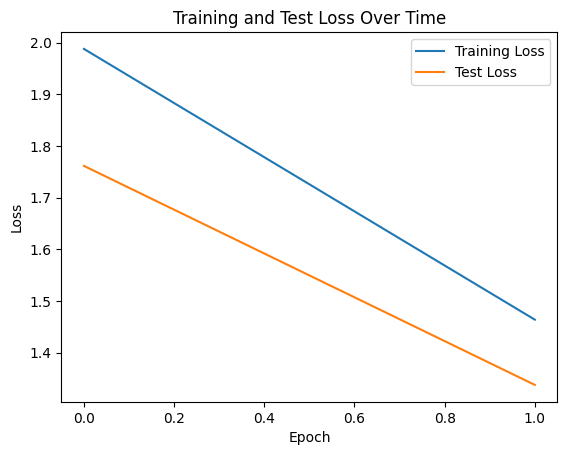

In [ ]:
# Plote gráficos de perda
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.show()


Generating Confusion Matrix: 100%|██████████| 782/782 [00:26<00:00, 29.72it/s]


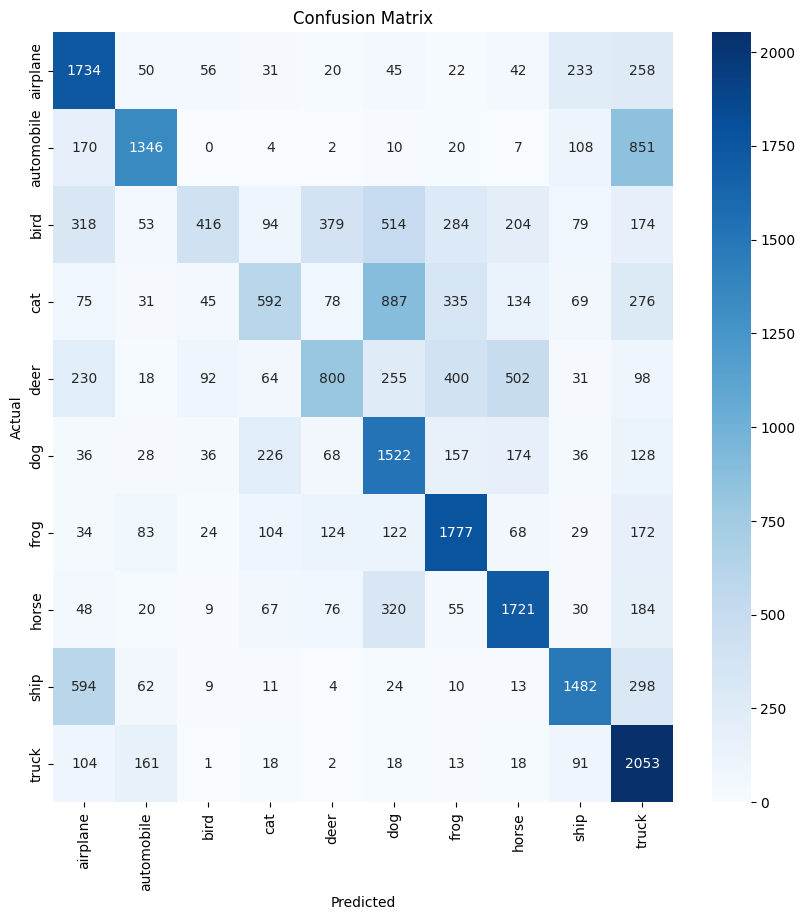

In [ ]:
plot_confusion_matrix(alexnet, trainloader, CIFAR10_CLASSES,device,'train')

Generating Confusion Matrix: 100%|██████████| 157/157 [00:05<00:00, 30.41it/s]


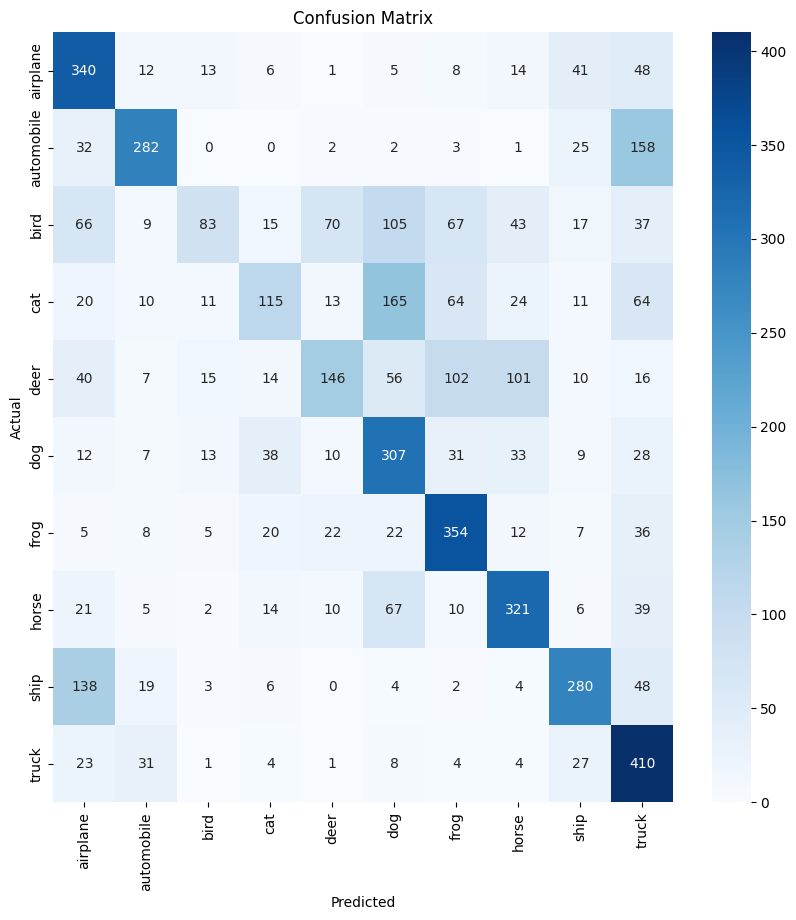

In [ ]:
plot_confusion_matrix(alexnet, testloader, CIFAR10_CLASSES, device,'test')

In [ ]:

# Function to evaluate the model and calculate metrics
def evaluate_model(model, dataloader, classes):
    model.eval()
    model = model.to(device)  # Move the model to the correct device
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        tqdm_dataloader = tqdm(dataloader, desc='Evaluating Model', dynamic_ncols=True)
        for inputs, labels in tqdm_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move the data to the correct device
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    tqdm_dataloader.close()

    # Calculate and print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=classes))

    # Calculate and plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(len(classes), len(classes)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Evaluating Model: 100%|██████████| 782/782 [00:26<00:00, 29.94it/s]


Classification Report:
              precision    recall  f1-score   support

    airplane       0.52      0.70      0.59      2491
  automobile       0.73      0.53      0.62      2518
        bird       0.60      0.17      0.26      2515
         cat       0.49      0.23      0.32      2522
        deer       0.52      0.32      0.40      2490
         dog       0.41      0.63      0.50      2411
        frog       0.58      0.70      0.63      2537
       horse       0.60      0.68      0.64      2530
        ship       0.68      0.59      0.63      2507
       truck       0.46      0.83      0.59      2479

    accuracy                           0.54     25000
   macro avg       0.56      0.54      0.52     25000
weighted avg       0.56      0.54      0.52     25000



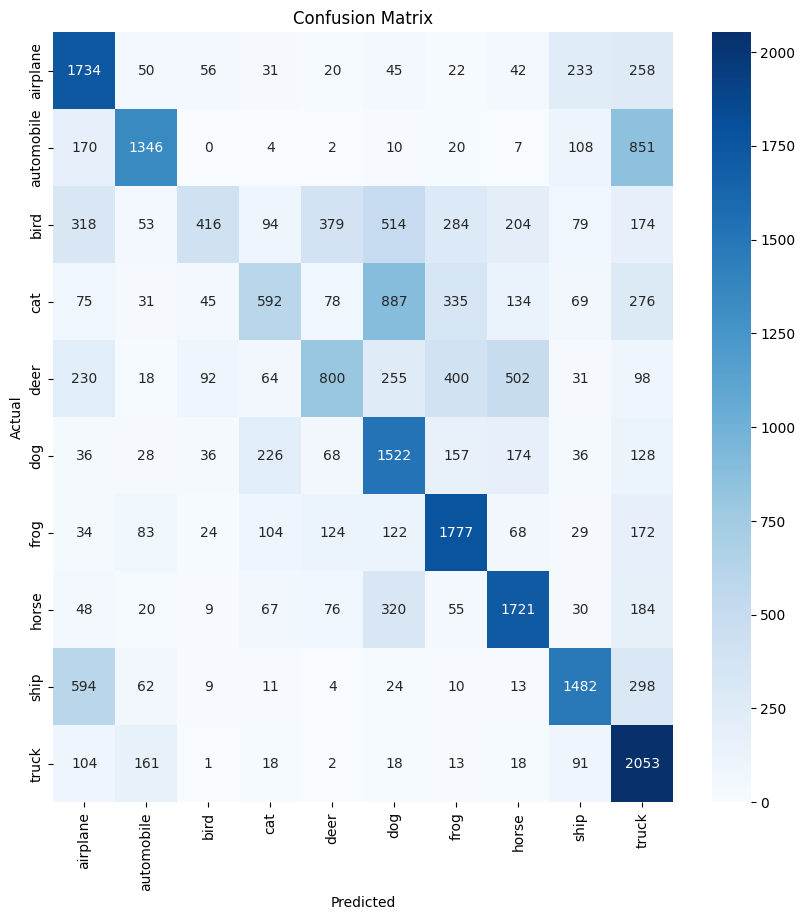

In [ ]:
# Evaluate the model on the training set
evaluate_model(alexnet, trainloader, CIFAR10_CLASSES)

Evaluating Model: 100%|██████████| 157/157 [00:05<00:00, 30.24it/s]


Classification Report:
              precision    recall  f1-score   support

    airplane       0.49      0.70      0.57       488
  automobile       0.72      0.56      0.63       505
        bird       0.57      0.16      0.25       512
         cat       0.50      0.23      0.32       497
        deer       0.53      0.29      0.37       507
         dog       0.41      0.63      0.50       488
        frog       0.55      0.72      0.62       491
       horse       0.58      0.65      0.61       495
        ship       0.65      0.56      0.60       504
       truck       0.46      0.80      0.59       513

    accuracy                           0.53      5000
   macro avg       0.55      0.53      0.51      5000
weighted avg       0.55      0.53      0.51      5000



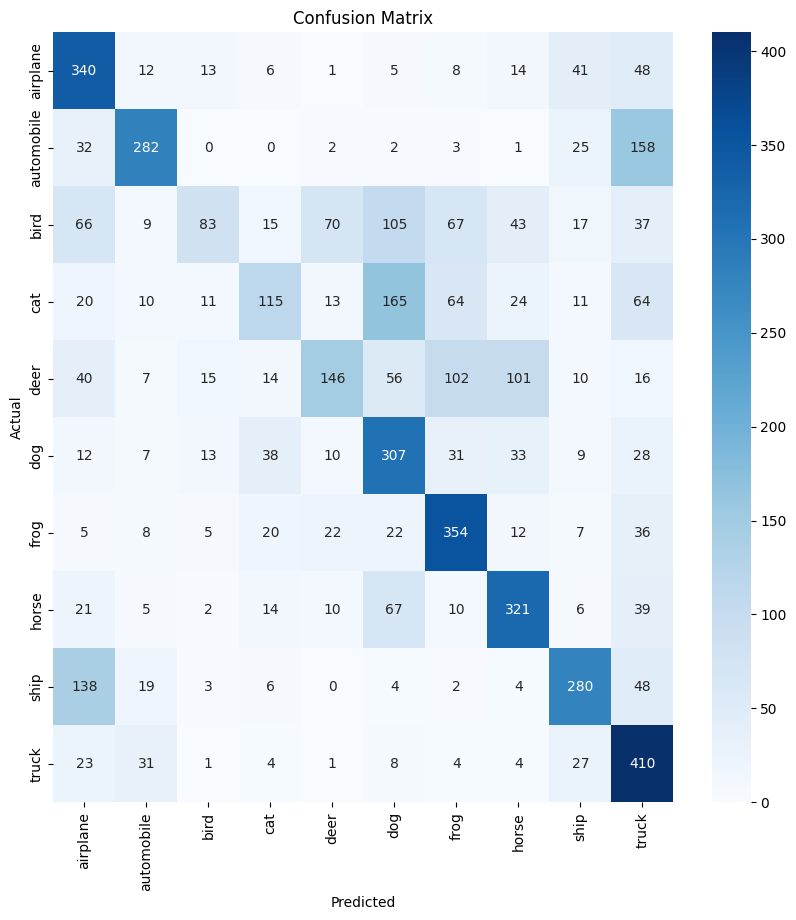

In [ ]:
# Evaluate the model on the test set
evaluate_model(alexnet, testloader, CIFAR10_CLASSES)